# Assignment 4. Becoming an Independent Data Scientist
## Commuter Rail Travel Time Relative to Weather Conditions in Boston,MA USA


### Region
Boston,MA USA

### Research Question
How do weather conditions, precipitation in particular, affect the travel times of MBTA commuter rail from North Station to Waltham on weekdays between 5 pm to 8 pm?

### Links to data

Public MBTA API:
https://www.mbta.com/developers/mbta-performance 
Code used to get MBTA data:
https://github.com/nataliak29/CourseraAppliedDataScienceSpecialization/blob/master/Course_2_Applied_Plotting%2C_Charting_%26_Data_Representation_in_Python/Assignment4/get_travel_times.py
MBTA data used:
https://github.com/nataliak29/CourseraAppliedDataScienceSpecialization/blob/master/Course_2_Applied_Plotting%2C_Charting_%26_Data_Representation_in_Python/Assignment4/traveltime_cr_all.csv

Weather data source:
https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND
Weather data:
https://github.com/nataliak29/CourseraAppliedDataScienceSpecialization/blob/master/Course_2_Applied_Plotting%2C_Charting_%26_Data_Representation_in_Python/Assignment4/1615554.csv

### Get MBTA data from public API

In [1]:
import json
import pandas as pd
import requests
import urllib.request
import urllib.parse
import time
from datetime import datetime, timedelta,date

#set ranges for the time period that will be retrieved and the departure and arrival stations.
Now = datetime.now()
main_from_date='01.01.2016'
from_time='17:00:00'
to_time='22:00:00'
from_stop='North Station'
to_stop='Waltham'
NumberOfDays = int((Now - datetime.strptime(main_from_date, "%d.%m.%Y")).days)

#create empty dataframe
traveltime= pd.DataFrame(columns=['RouteID','FromStop','ToStop','Departure','Arrival','TravelTimeMin'])

#loop through every day between two dates 
for single_date in (datetime.strptime(main_from_date, "%d.%m.%Y") + timedelta(n) for n in range(NumberOfDays)):
    from_date_time = datetime.strptime(str(str(single_date.strftime("%d.%m.%Y"))+' '+from_time), "%d.%m.%Y %H:%M:%S")
    to_date_time = datetime.strptime(str(str(single_date.strftime("%d.%m.%Y"))+' '+to_time), "%d.%m.%Y %H:%M:%S")


    pattern = '%d.%m.%Y %H:%M:%S'
    from_date_time_epoch =int(from_date_time.timestamp())
    to_date_time_epoch =int(to_date_time.timestamp())



    params = urllib.parse.urlencode( {
        "api_key": 'wX9NwuHnZU2ToO7GmGR9uw', #public api_key
        "format": 'json',
        "from_stop": from_stop,
        "to_stop":  to_stop,
        "from_datetime":from_date_time_epoch,
        "to_datetime":to_date_time_epoch
        })

    url='http://realtime.mbta.com/developer/api/v2.1/traveltimes?%s' % params

    with urllib.request.urlopen(url) as f:
        data=f.read().decode('utf-8')


    js= json.loads(data)
#print(json.dumps(js, indent=2))

    for i in range(len(js['travel_times'])):
        #print(js['travel_times'][i]['route_id'])

        traveltime.loc[len(traveltime)] = ([
                        js['travel_times'][i]['route_id'],
                        from_stop,
                        to_stop,
                        time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(js['travel_times'][i]['dep_dt']))),
                        time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(js['travel_times'][i]['arr_dt']))),
                        float(js['travel_times'][i]['travel_time_sec'])/60,

                        ])
traveltime.to_csv('traveltime_cr_all.csv')        
print(traveltime.head())



        RouteID       FromStop   ToStop            Departure  \
0  CR-Fitchburg  North Station  Waltham  2016-01-15 17:07:50   
1  CR-Fitchburg  North Station  Waltham  2016-01-15 17:31:47   
2  CR-Fitchburg  North Station  Waltham  2016-01-15 17:52:20   
3  CR-Fitchburg  North Station  Waltham  2016-01-15 18:23:18   
4  CR-Fitchburg  North Station  Waltham  2016-01-18 17:52:53   

               Arrival  TravelTimeMin  
0  2016-01-15 17:29:52      22.033333  
1  2016-01-15 17:52:19      20.533333  
2  2016-01-15 18:12:52      20.533333  
3  2016-01-15 18:43:49      20.516667  
4  2016-01-18 18:11:53      19.000000  


### Clean data and prepare for charting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mt
from datetime import date
from datetime import datetime
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

#Get travel time data from MBTA public API

mbta= pd.read_csv('traveltime_cr_all.csv',usecols = [1,2,3,4,5,6])
mbta['DATE']=pd.to_datetime(mbta['Departure'])
mbta['Month']=mbta['DATE'].dt.month
mbta['Year']=mbta['DATE'].dt.year
mbta['DepartureHour']=mbta['DATE'].dt.hour
mbta['DayOfTheWeek'] = mbta['DATE'].dt.dayofweek
mbta=mbta[(mbta['DepartureHour']!=20)]
mbta=mbta[(mbta['DayOfTheWeek']!=6) & (mbta['DayOfTheWeek']!=5)]
#print(mbta['Year'])
avgtraveltime=( pd.DataFrame(mbta.groupby(['Year','Month'])['TravelTimeMin'].mean()) )
avgtraveltime.reset_index(inplace=True)

weather= pd.read_csv('1615554.csv',usecols = [1,5,9,10,13,14])
weather=weather[weather['NAME']=='BOSTON, MA US']
weather['my_date']=pd.to_datetime(weather['DATE'])
weather['Month']=weather['my_date'].dt.month
weather['Year']=weather['my_date'].dt.year
avgprcp=( pd.DataFrame(weather.groupby(['Year','Month'])['PRCP'].mean()) )
avgprcp.reset_index(inplace=True)


merged_data = pd.merge(avgtraveltime, avgprcp, how='left', on=['Year','Month'])
merged_data.reset_index(inplace=True)
merged_data['Day']=1
merged_data['datem'] = pd.to_datetime(merged_data[['Year','Month','Day']],format='%Y%m')
print(merged_data.head())

travel=np.array(merged_data['TravelTimeMin'])
PRCP=np.array(merged_data['PRCP'])
datenp=np.array(merged_data['datem'])




   index  Year  Month  TravelTimeMin      PRCP  Day      datem
0      0  2016      1      21.316667  0.105484    1 2016-01-01
1      1  2016      2      21.067901  0.143793    1 2016-02-01
2      2  2016      3      21.056410  0.101935    1 2016-03-01
3      3  2016      4      20.699425  0.097000    1 2016-04-01
4      4  2016      5      19.988690  0.091290    1 2016-05-01


### Plot the chart

<IPython.core.display.Javascript object>


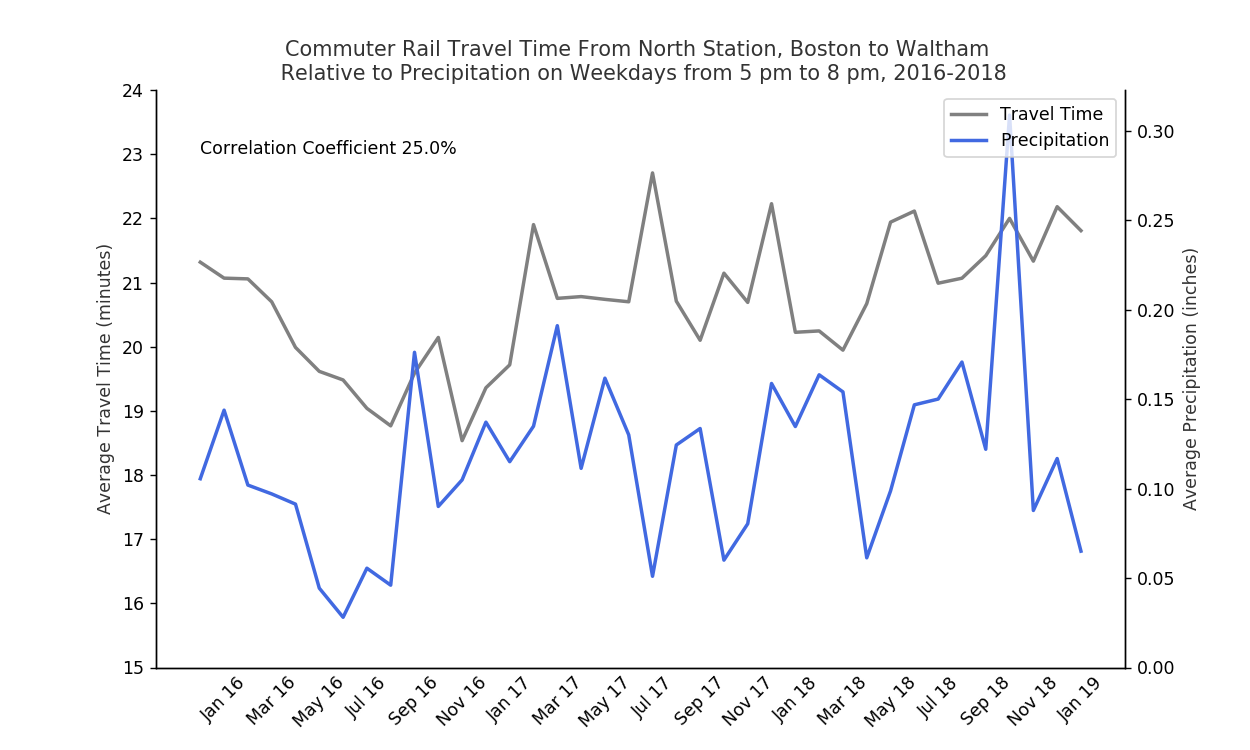

(0, 0.32269677419354836)

In [6]:

%matplotlib notebook
import matplotlib.pyplot as plt

cc=np.corrcoef(travel, PRCP)[0][1]
#print('Correlation Coefficient',cc)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)

ax1.plot(travel, '-',linewidth=2,color='grey', label='Travel Time')
ax1.spines['top'].set_visible(False)
ax1.set_ylabel('Average Travel Time (minutes)', alpha=0.8)

ticklabels = [datetime.date( (merged_data.loc[item,'datem'])).strftime( "%b %y") for item in merged_data.index]
ax1.set_xticks(np.arange(1,40))
ax1.set_xticklabels(ticklabels)

for label in ax1.xaxis.get_ticklabels():
    label.set_visible(False)
plt.locator_params(axis='x')

for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)
plt.locator_params(axis='x')

ax1.tick_params(axis=u'x', which=u'both',length=0)

for item in ax1.xaxis.get_ticklabels():
    item.set_rotation(45)

ax2 = ax1.twinx()
ax2.plot(PRCP, '-',linewidth=2,color='royalblue', label='Precipitation')
ax2.set_ylabel('Average Precipitation (inches)', alpha=0.8)
ax2.spines['top'].set_visible(False)



plt.title("Commuter Rail Travel Time From North Station, Boston to Waltham \n Relative to Precipitation on Weekdays from 5 pm to 8 pm, 2016-2018", loc='center', alpha=0.8,fontsize=12)
ax1.annotate('Correlation Coefficient %s' %round(100*cc,0)+'%',xy=(0, 20), xytext=(0, 23))
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
ax1.set_ylim(15,24)
ax2.set_ylim(0)
#plt.show()


### Discussion

The visual illustrates how travel times from North Station in Boston to Waltham relates to precipitation. 

The travel time data comes from MBTA (Massachusetts Bay Transportation Authority) commuter rail performance data (though public API) and the research concentrated only on the rush hour after work during the weekdays, when the departure time is between 5 pm and 8 pm. Travel times are collected for every train in the rush hour between Jan 2016 and Jan 2018 departing from North Station (Boston's center of the city) to Waltham (Boston Greater area town). The weather data is collected on daily basis as well. 
In order to eliminate noise coming from daily fluctuations and make chart more illustrative, monthly averages of the travel times and precipitation were calculated.

The correlation coefficient between travel times and precipitation is 25% which is supported by the chart where some of the spikes and dips of the travel times in 2016 are corresponded by spikes and dips of the precipitation level. However, from May 2017 to May 2018 the lines move in the opposite directions. 

The chart proves that there is some relationship between the travel times and precipitation but there are definitely other factors that affect the travel times and further research is needed. Additionally, the dataset is constrained to limited number of data points (only 3 years range) because of availability of MBTA performance data.


### Discussion  of Alberto Cairo’s principles of truth, beauty, function, and insight

Truthfulness - The visual shows what the averages of travel times and averages of precipitation, does not misleading the viewer since it has correctly labeled axis with measurement units and legend. 

Beauty - The chart does not have unnecessary elements and it not cluttered. 

Functionality - The choice of color for the precipitation line is based on the natural association of blue color with water, so the choice of that color to illustrate amount atmospheric water vapor is intentional. The horizontal axis is label using both month and year which is useful to follow the trend over time.

Insightfulness - The chart gives a viewer the idea of how much the two lines move together over time and the correlation coefficient quantifies this movement which gives a good insight into the data.